# Predicting Car Fuel Consumption

In this example we are going to create a regression model with Keras Tensorflow which aims to predict the efficiency of a fleet of cars.

The dataset can be found at:

[Auto MPG Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/)

We are going to put in practice some techniques to tackle this regresion problem, like "bucketizing" numerical features.

Also though it is a rather simple problem, we will apply some best practices in terms of choices for initialization, callbacks, hyperparameter tunning, optimizer, batch size, learning rate, dropout etc...


In [1]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import os, sys

import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import seaborn as sns
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler,  KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


## Import Dataset

In [2]:
# The dataset can be read directly from the url, or if you do not have connection, from a local folder like ../data

#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

path = '../data/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(path, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Attribute Information:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete


In [62]:
df['Origin'].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

In [57]:
df.iloc[:,1:6]

,Cylinders,Displacement,Horsepower,Weight,Acceleration
0,8,307.0,130.0,3504.0,12.0
1,8,350.0,165.0,3693.0,11.5
2,8,318.0,150.0,3436.0,11.0
3,8,304.0,150.0,3433.0,12.0
4,8,302.0,140.0,3449.0,10.5
...,...,...,...,...,...
393,4,140.0,86.0,2790.0,15.6
394,4,97.0,52.0,2130.0,24.6
395,4,135.0,84.0,2295.0,11.6
396,4,120.0,79.0,2625.0,18.6


## Dataset Preprocesssing

In [5]:
# Count NaN
print(df.isnull().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [7]:
# As there are only 6 null values we drop them in a new dataframe
df_clean = df.dropna().reset_index(drop=True)
df_clean.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Feature Importance Calculation

In the following cells we calculate the influence of the input variables over the MPG (miles per gallon), which is the intended variable to be predicted.

The results are the same with both procedures.

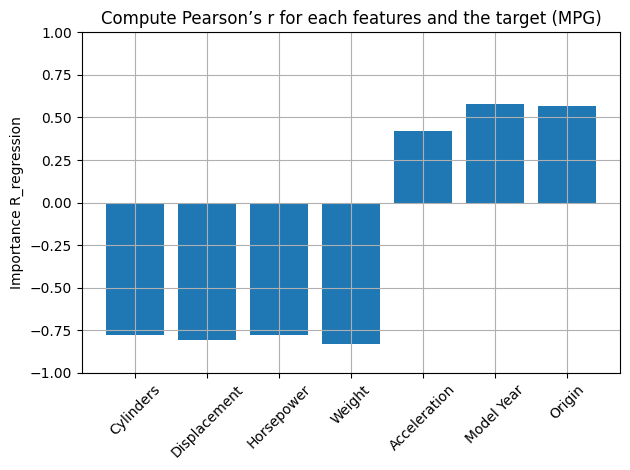

In [20]:
from sklearn.feature_selection import r_regression
# For further information on r_regression look at:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html#sklearn.feature_selection.r_regression

X= df_clean.iloc[:,1:].values
y = df_clean.iloc[:,0].values
importances = r_regression(X, y, center=True, force_finite=True)

fig, ax = plt.subplots()
ax.bar(range(7), importances, align = 'center')
ax.set_ylabel('Importance R_regression')
ax.set_xticks(range(7))
ax.set_xticklabels(df_clean.columns[1:], rotation = 45)
plt.title('Compute Pearson’s r for each features and the target (MPG)')
plt.ylim([-1,1])
plt.tight_layout()
plt.grid(True)
plt.show()

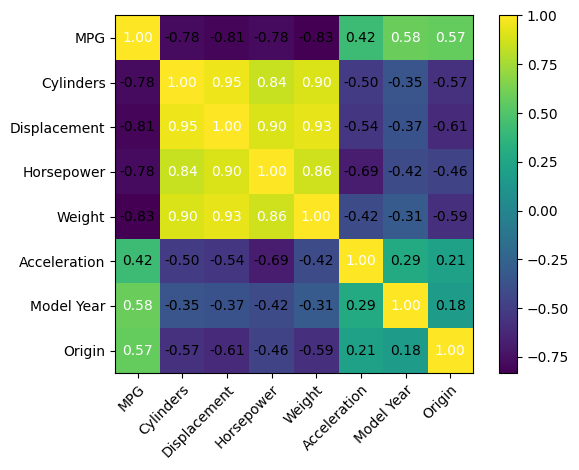

In [16]:
# The correlation matrix created with S.Raschka´s mlxtend library, provides the same results.
# Look at the first row where we compare the effect over MPG of the rest of the input variables.

from mlxtend.plotting import heatmap

cm = np.corrcoef(df_clean.values.T)
hm = heatmap(cm, row_names = df_clean.columns, column_names = df_clean.columns)
plt.tight_layout()
plt.show()

## Model Creation

We are going to create the model by using the Functional API, preprocessing the data in the model

thanks to the Keras Preprocessing Layers:
[Keras Preprocessing Layers](https://keras.io/api/layers/preprocessing_layers/)

Another way would be by using Scikit-Learn StandardScaler,  KBinsDiscretizer, but doing it in this way we keep 
all together in the same model ready for deployment.


### Preprocessing With Keras Preprocessing Layers

As numerical inputs we have:
- cylinders: multi-valued discrete
- displacement: continuous
- horsepower: continuous
- weight: continuous
- acceleration: continuous

These inputs need to be standarized

The following ones:
- model year: multi-valued discrete
- origin: multi-valued discrete

Need to be treated in a different way in the Pipeline, the "model year" can be discretized (bucketized) in different bins, whereas the "origin" can be encoded using "One-Hot Vectors" or "Embeddings". 

In [66]:
# Model inputs 

df_train, df_test = train_test_split(df, train_size = 0.7, random_state= 1)


In [67]:
df_train

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
350,34.7,4,105.0,63.0,2215.0,14.9,81,1
59,23.0,4,97.0,54.0,2254.0,23.5,72,2
120,19.0,4,121.0,112.0,2868.0,15.5,73,2
12,15.0,8,400.0,150.0,3761.0,9.5,70,1
349,34.1,4,91.0,68.0,1985.0,16.0,81,3
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
255,25.1,4,140.0,88.0,2720.0,15.4,78,1
72,15.0,8,304.0,150.0,3892.0,12.5,72,1
235,26.0,4,97.0,75.0,2265.0,18.2,77,3


In [ ]:
# Input Layers
numerical_ = keras.layers.Input(shape = [5], name = 'numerical_features')
bucketized_ = keras.layers.Input(shape = [1], name = 'Model_Age_Bucketized')
categorical_ = keras.layers.Input(shape = [1], name = ' Origin_One_Hot_Encoded')

# It is needed to Standarize the numerical inputs, to discretize into buckets the 
# manufacturing year, and to embed or one-hot encode the numerical categorical features for
# the origin.
std_layer = keras.layers.Normalization(axis=-1)
std_layer.adapt(df.iloc[:,1:6].values)
bucket_layer = keras.layers.Discretization( 
    num_bins = 4,
    output_mode="int"
    )
bucket_layer.adapt(df.iloc[:,6].values)

bucket_year = bucket_layer(df.iloc[:,6].values)
vocab = [1,2,3] 
cat_one_hot_layer = keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
cat_one_hot_layer.adapt(df.iloc[:,7].values)
one_hot_origin = cat_one_hot_layer(df.iloc[:,7].values)

input_shape = x_train.shape[1:]
classes = 10

# Create a Normalization layer and set its internal state using the training data
normalizer = keras.layers.Normalization()
normalizer.adapt(x_train)

# Create a model that include the normalization layer
inputs = keras.Input(shape=input_shape)
x = normalizer(inputs)

In [55]:
def build_model():

    return model

<KerasTensor: shape=(None, 3072) dtype=float32 (created by layer 'normalization')>

## Model Evaluation

## Model Optimization 

## Run Optimized Model

## Save Basic and Optimized Model